# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## In this capstone challenge I am going to build a ML model to predict weather the members who received & viewed an offer are going to complete it or not. First I am going to clean and preprocess each table then combine the needed data into one dataframe. After that, I am going to prepare the combined datafram for the ML model. 

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
% matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score , f1_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data understanding

In [3]:
print(profile.describe())
print(profile.shape)
profile.head()

                age  became_member_on         income
count  17000.000000      1.700000e+04   14825.000000
mean      62.531412      2.016703e+07   65404.991568
std       26.738580      1.167750e+04   21598.299410
min       18.000000      2.013073e+07   30000.000000
25%       45.000000      2.016053e+07   49000.000000
50%       58.000000      2.017080e+07   64000.000000
75%       73.000000      2.017123e+07   80000.000000
max      118.000000      2.018073e+07  120000.000000
(17000, 5)


,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
sum(profile.gender.isnull())

2175

In [5]:
len(profile.loc[profile['age'] == 118])

2175

Text(0.5,0,'Age of Members')

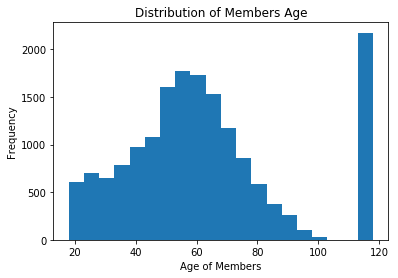

In [6]:
# histogram of members' age
members_age = profile['age'].plot(kind='hist', bins=20, title='Distribution of Members Age')
members_age.set_xlabel("Age of Members")

Text(0.5,0,'Income')

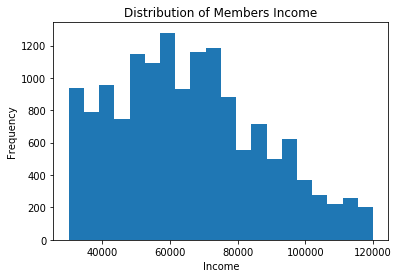

In [7]:
# histogram of members' income
plt.figure()
member_income = profile['income'].plot(kind='hist', bins=20, title='Distribution of Members Income')
member_income.set_xlabel("Income")

In [8]:
print(portfolio.describe())
print(portfolio.shape)
portfolio.head()

       difficulty   duration     reward
count   10.000000  10.000000  10.000000
mean     7.700000   6.500000   4.200000
std      5.831905   2.321398   3.583915
min      0.000000   3.000000   0.000000
25%      5.000000   5.000000   2.000000
50%      8.500000   7.000000   4.000000
75%     10.000000   7.000000   5.000000
max     20.000000  10.000000  10.000000
(10, 6)


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [9]:
print(transcript.describe())
print(transcript.shape)
transcript.head()

                time
count  306534.000000
mean      366.382940
std       200.326314
min         0.000000
25%       186.000000
50%       408.000000
75%       528.000000
max       714.000000
(306534, 4)


,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


# -------------------------------------------------------------------------------------

# Data Cleaning/Preprocessing

### Profile data

In [10]:
# Remove member with age 118
profile.drop(profile[profile['age'] == 118].index, inplace = True)

In [11]:
len(profile.id.unique())

14825

In [12]:
profile['age'].mean()

54.393524451939292

In [13]:
# change the members' age who are older than 90 with the mean, because it is nearly impossible to have 219 member are ordering starbucks through an app
profile['age'] = profile['age'].replace(profile[profile['age'] > 90]['age'], 54)

In [14]:
# Grouping the age column into 4 categories for easy analysis, here I identified the indecies for each category
_17_29_idx = profile[(profile.age > 17) & (profile.age < 30)].index
_30_49_idx = profile[(profile.age > 29) & (profile.age < 50)].index
_50_69_idx = profile[(profile.age > 49) & (profile.age < 70)].index
avove_69_idx = profile[(profile.age > 69)].index

In [15]:
# Now we change the values for each category
profile.loc[(profile.index.isin(_17_29_idx)), 'age'] = '[17-29]'
profile.loc[(profile.index.isin(_30_49_idx)), 'age'] = '[30-49]'
profile.loc[(profile.index.isin(_50_69_idx)), 'age'] = '[50-69]'
profile.loc[(profile.index.isin(avove_69_idx)), 'age'] = '[70 & above]'

In [16]:
# apply one-hot encoded features to age and remove the original column

profile = pd.concat([profile, pd.get_dummies(profile['age'])], axis=1)
profile = profile.drop(columns=['age'])

In [17]:
# calculate the number of days since the custome became a member

import datetime

profile['days_of_membership'] = datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date
profile['days_of_membership'] = profile['days_of_membership'].dt.days

In [18]:
# drop became_member_on column
profile = profile.drop(columns=['became_member_on'])

In [19]:
# apply one-hot encoded features to gender and remove the original column

profile = pd.concat([profile, pd.get_dummies(profile['gender'])], axis=1)
profile = profile.drop(columns=['gender'])

In [20]:
# rename the id column to member_id
profile.rename(columns={'id':'member_id'}, inplace=True)

In [21]:
profile

,member_id,income,[17-29],[30-49],[50-69],[70 & above],days_of_membership,F,M,O
1,0610b486422d4921ae7d2bf64640c50b,112000.0,0,0,1,0,1255,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,0,0,1,1322,1,0,0
5,e2127556f4f64592b11af22de27a7932,70000.0,0,0,1,0,970,0,1,0
8,389bc3fa690240e798340f5a15918d5c,53000.0,0,0,1,0,1046,0,1,0
12,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,0,1,0,1136,0,1,0
13,aa4862eba776480b8bb9c68455b8c2e1,57000.0,0,0,1,0,1197,1,0,0
14,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0,1,0,0,0,2503,0,1,0
15,31dda685af34476cad5bc968bdb01c53,71000.0,0,0,1,0,1775,1,0,0
16,62cf5e10845442329191fc246e7bcea3,52000.0,0,1,0,0,2230,0,1,0
18,6445de3b47274c759400cd68131d91b4,42000.0,0,0,1,0,1086,0,1,0


### Portfolio data

In [22]:
# Create a function to apply one-hot encoded features to Channels
def chann_col (col_names, df):
    '''
    INPUT:
    col_names = list of the columns names to be the features (in this case will be the channels)
    df = dataframe
    
    OUTPUT:
    df = the datafram after applying one-hot encoded features
    '''
    
    for col_name in col_names:
        df.insert(loc = df.shape[1],column = col_name, value = 0, allow_duplicates=False)
        for i in df.index:
            if col_name in df.iloc[i]['channels']:
                df.loc[df.index == i, col_name] = 1
            else:
                df.loc[df.index == i, col_name]  = 0
    
    return df

In [23]:
# apply the function to portfolio datafram
uniq_channs = ['web', 'email', 'mobile', 'social']
portfolio = chann_col(uniq_channs, portfolio)

In [24]:
# drop channels column
portfolio = portfolio.drop(columns=['channels'])

In [25]:
# apply one-hot encoded features to offer_type and remove the original column

portfolio = pd.concat([portfolio, pd.get_dummies(portfolio['offer_type'])], axis=1)
portfolio = portfolio.drop(columns=['offer_type'])

In [26]:
# rename the id column to offer_id
portfolio.rename(columns={'id':'offer_id'}, inplace=True)

In [27]:
portfolio.columns

Index(['difficulty', 'duration', 'offer_id', 'reward', 'web', 'email',
       'mobile', 'social', 'bogo', 'discount', 'informational'],
      dtype='object')

In [28]:
# arrange the columns
portfolio = portfolio[['offer_id', 'difficulty','duration', 'reward', 'web', 'email', 'mobile', 'social', 'bogo', 'discount', 'informational']]

In [29]:
portfolio

,offer_id,difficulty,duration,reward,web,email,mobile,social,bogo,discount,informational
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,0,1,1,1,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,1,1,1,1,1,0,0
2,3f207df678b143eea3cee63160fa8bed,0,4,0,1,1,1,0,0,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,1,1,1,0,1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,1,1,0,0,0,1,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,7,3,1,1,1,1,0,1,0
6,fafdcd668e3743c1bb461111dcafc2a4,10,10,2,1,1,1,1,0,1,0
7,5a8bc65990b245e5a138643cd4eb9837,0,3,0,0,1,1,1,0,0,1
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,1,1,1,1,0,0
9,2906b810c7d4411798c6938adc9daaa5,10,7,2,1,1,1,0,0,1,0


### Transcript data

In [30]:
# get the unique values for the event column
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [31]:
transcript.shape

(306534, 4)

In [32]:
# copy only the rows that have offers' status (removing the transaction) into a nwe dataframe
offer_df = transcript.drop(transcript[transcript['event'] == 'transaction'].index)

In [33]:
# check the unique values in the event column
offer_df['event'].unique()

array(['offer received', 'offer viewed', 'offer completed'], dtype=object)

In [34]:
# sort the value by person
offer_df.sort_values(by='person')

,event,person,time,value
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
228423,offer completed,0009655768c64bdeb2e877511632db8f,528,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
233413,offer viewed,0009655768c64bdeb2e877511632db8f,540,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
55972,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
258884,offer completed,0009655768c64bdeb2e877511632db8f,576,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
247879,offer received,0009655768c64bdeb2e877511632db8f,576,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
153401,offer received,0009655768c64bdeb2e877511632db8f,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'}


In [35]:
# Get the offers' id and add them in a new column
offer_df['offer_id'] = offer_df['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])

In [36]:
# drop the value column
offer_df = offer_df.drop(columns=['value'])

In [37]:
# rename the person column to member_id
offer_df.rename(columns={'person':'member_id'}, inplace=True)

In [38]:
offer_df

,event,member_id,time,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0
5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d
6,offer received,c4863c7985cf408faee930f111475da3,0,2298d6c36e964ae4a3e7e9706d1fb8c2
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
9,offer received,31dda685af34476cad5bc968bdb01c53,0,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [39]:
# combine all the events for the same offer_id for each member in one row
combi_offer_df = offer_df.groupby(['member_id', 'offer_id'])['event'].apply(','.join).reset_index()

In [40]:
combi_offer_df

,member_id,offer_id,event
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,"offer received,offer completed"
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,"offer received,offer viewed"
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,"offer received,offer viewed"
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,"offer received,offer completed,offer viewed"
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,"offer received,offer completed,offer viewed"
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,"offer received,offer viewed,offer received,off..."
6,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,"offer received,offer viewed,offer completed"
7,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,"offer received,offer viewed,offer completed"
8,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,"offer received,offer viewed"
9,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,"offer received,offer viewed"


In [41]:
# capture all the event in one list for comparision
events_list = combi_offer_df['event'].tolist()

In [42]:
# function that take a keyword and match it with each row in the event column

def offer_one_hot_encoding (keyword):
    
    '''
    INPUT:
    keyword = the word that is going to be the matching criteria
    
    OUTPUT:
    val = a list of the result after matching the keyword for each row
    '''
    
    val = []
    for i in range(len(events_list)):
        if keyword in events_list[i]:
            val.append(1)
        else:
            val.append(0)

    return val

In [43]:
# applying the function to have a one-hot encoding for the offers that have been viewed/completed
combi_offer_df['offer_viewed'] = offer_one_hot_encoding('viewed')
combi_offer_df['offer_completed'] = offer_one_hot_encoding('completed')

In [44]:
# drop the event column
combi_offer_df = combi_offer_df.drop(columns=['event'])

In [45]:
combi_offer_df

,member_id,offer_id,offer_viewed,offer_completed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,1,0
6,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1
7,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1
8,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,1,0
9,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,1,0


# -------------------------------------------------------------------------------------

## Combine all the needed data into one dataframe and prepare it for our model

In [46]:
# merge the offer data with portfolio to get the offers' details
offer_and_portfolio = pd.merge(combi_offer_df, portfolio, on='offer_id')

In [47]:
# now we include the members' details
final_df = pd.merge(offer_and_portfolio, profile, on='member_id')

In [48]:
# drop the member_id & offer_id columns
final_df = final_df.drop(columns=['member_id', 'offer_id'])

In [49]:
final_df.head()

,offer_viewed,offer_completed,difficulty,duration,reward,web,email,mobile,social,bogo,...,informational,income,[17-29],[30-49],[50-69],[70 & above],days_of_membership,F,M,O
0,0,1,10,7,2,1,1,1,0,0,...,0,72000.0,0,1,0,0,1340,0,1,0
1,1,0,0,4,0,1,1,1,0,0,...,1,72000.0,0,1,0,0,1340,0,1,0
2,1,0,0,3,0,0,1,1,1,0,...,1,72000.0,0,1,0,0,1340,0,1,0
3,1,1,5,5,5,1,1,1,1,1,...,0,72000.0,0,1,0,0,1340,0,1,0
4,1,1,10,10,2,1,1,1,1,0,...,0,72000.0,0,1,0,0,1340,0,1,0


In [50]:
# normalize the uncoded columns
scaler = MinMaxScaler()

final_df[['difficulty', 'duration', 'reward', 'income', 'days_of_membership']] = \
scaler.fit_transform(final_df[['difficulty', 'duration', 'reward', 'income', 'days_of_membership']])

In [51]:
final_df

,offer_viewed,offer_completed,difficulty,duration,reward,web,email,mobile,social,bogo,...,informational,income,[17-29],[30-49],[50-69],[70 & above],days_of_membership,F,M,O
0,0,1,0.50,0.571429,0.2,1,1,1,0,0,...,0,0.466667,0,1,0,0,0.252880,0,1,0
1,1,0,0.00,0.142857,0.0,1,1,1,0,0,...,1,0.466667,0,1,0,0,0.252880,0,1,0
2,1,0,0.00,0.000000,0.0,0,1,1,1,0,...,1,0.466667,0,1,0,0,0.252880,0,1,0
3,1,1,0.25,0.285714,0.5,1,1,1,1,1,...,0,0.466667,0,1,0,0,0.252880,0,1,0
4,1,1,0.50,1.000000,0.2,1,1,1,1,0,...,0,0.466667,0,1,0,0,0.252880,0,1,0
5,0,0,0.50,0.571429,0.2,1,1,1,0,0,...,0,0.388889,1,0,0,0,0.392759,1,0,0
6,1,0,0.00,0.000000,0.0,0,1,1,1,0,...,1,0.388889,1,0,0,0,0.392759,1,0,0
7,1,1,0.50,1.000000,0.2,1,1,1,1,0,...,0,0.388889,1,0,0,0,0.392759,1,0,0
8,0,0,1.00,1.000000,0.5,1,1,0,0,0,...,0,0.388889,1,0,0,0,0.392759,1,0,0
9,0,0,0.50,0.571429,0.2,1,1,1,0,0,...,0,0.188889,0,0,1,0,0.125617,0,1,0


In [52]:
final_df.columns

Index(['offer_viewed', 'offer_completed', 'difficulty', 'duration', 'reward',
       'web', 'email', 'mobile', 'social', 'bogo', 'discount', 'informational',
       'income', '[17-29]', '[30-49]', '[50-69]', '[70 & above]',
       'days_of_membership', 'F', 'M', 'O'],
      dtype='object')

In [53]:
# split the data
X = final_df[['offer_viewed', 'difficulty', 'duration', 'reward','web', 'email', 'mobile', 'social', 'bogo', \
        'discount', 'informational','income', '[17-29]', '[30-49]', '[50-69]', '[70 & above]',\
        'days_of_membership', 'F', 'M', 'O']]

y = final_df['offer_completed']

In [54]:
# divide into test/train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# -------------------------------------------------------------------------------------

## Build the model (Decision Tree Classifier)

In [55]:
model = DecisionTreeClassifier()

# train the model
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [56]:
# predict hte test data
pred = model.predict(X_test)

In [57]:
# Evaluate our prediction
print('DecisionTreeClassifier F1 Score: ', model.score(X_train, y_train))
print('DecisionTreeClassifier Predition Accuracy: ', accuracy_score(y_test, pred))

DecisionTreeClassifier F1 Score:  0.999010044427
DecisionTreeClassifier Predition Accuracy:  0.736853541938


## Try more sophisticated algorithm to see if the prediction will be better

In [58]:
# I will use Random Forest classifier
from sklearn.ensemble import RandomForestClassifier

model2 = RandomForestClassifier()

model2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [59]:
pred2 = model2.predict(X_test)

# Evaluate our prediction
print('RandomForestClassifier F1 Score: ', model.score(X_train, y_train))
print('RandomForestClassifier Predition Accuracy: ', accuracy_score(y_test, pred2))

RandomForestClassifier F1 Score:  0.999010044427
RandomForestClassifier Predition Accuracy:  0.750398377517


## Which model performed better?

### We can see a slight enhancement in the accurecy when we used the Random Forest classifier 75.04% compared to the Decision Tree Classifier 73.7%

## No let's try GridSearchCV to see if we can improve our model more!

In [65]:
from sklearn.model_selection import GridSearchCV

model_final = RandomForestClassifier()

# identify and tune the parameters we want
parameters =  {'min_samples_split' : np.linspace(0.1, 1.0, 10, endpoint=True), 'max_depth': np.linspace(1, 32, 32, endpoint=True)}


# Perform grid search on our model
grid_obj = GridSearchCV(model_final, parameters)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_est = grid_fit.best_estimator_

In [66]:
# Make predictions
pred3 = best_est.predict(X_test)

# Evaluation of  our prediction
print('RandomForestClassifier F1 Score: ', model.score(X_train, y_train))
print('RandomForestClassifier Predition Accuracy: ', accuracy_score(y_test, pred3))

RandomForestClassifier F1 Score:  0.999010044427
RandomForestClassifier Predition Accuracy:  0.759814573374


## By tunning some of the parameters, our model has been enhanced by only 0.9%

## Results discussion

### I think I got excellent results with my first attempt, we can try different classifiers like Gradient Boosted Trees and compare the results of each model. Also, we can improve the model by tune other parameters and find the optimal ones that can enhance the prediction of the model.

# Summary

### The first step in this project was the data exploration. Then, I did data wrangling to prepare each table for the next step. After that, I combined all the needed data into one table and prepared it to be ready for our model. Finally, I have built a Decision Tree Classifier which gave me 73.3% accuracy. Then. I tried a more sophisticated algorithm to see if the prediction will be better, so, I built a Random Forest classifier that gave me 75.04% accuracy (enhanced by 2% compared to the Decision Tree). Lastly, I tunned some of the parameters to improve the model and it has improved it only by 0.9%